In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
from pathlib import Path

from collections import Counter
import random
import operator
from tqdm import tqdm
import time

from wordcloud import WordCloud
from string import punctuation
import nltk
import subprocess

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertModel, BertTokenizer

from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
import evaluate

%matplotlib inline

In [3]:
data_full = pd.read_csv('HateSpeechDatasetBalanced.csv')

num_rows, num_cols = data_full.shape
print(f'Rows: {num_rows},  columns: {num_cols}')

data_full.sample(3)

Rows: 726119,  columns: 2


,Content,Label
386432,you have no authority to be threatening to blo...,0
253721,demographics of lebanon thanks for experimenti...,0
96406,fuck it i hate my husband,0


In [4]:
data_full.groupby('Label').count()

,Content
Label,
0,361594
1,364525


In [5]:
#The dataset is quite big so we take just 4000 examples of each class
df1 = data_full.query('Label == 0').sample(4000)
df2 = data_full.query('Label == 1').sample(4000)
data = pd.concat([df1, df2], ignore_index=True)
data.shape

(8000, 2)

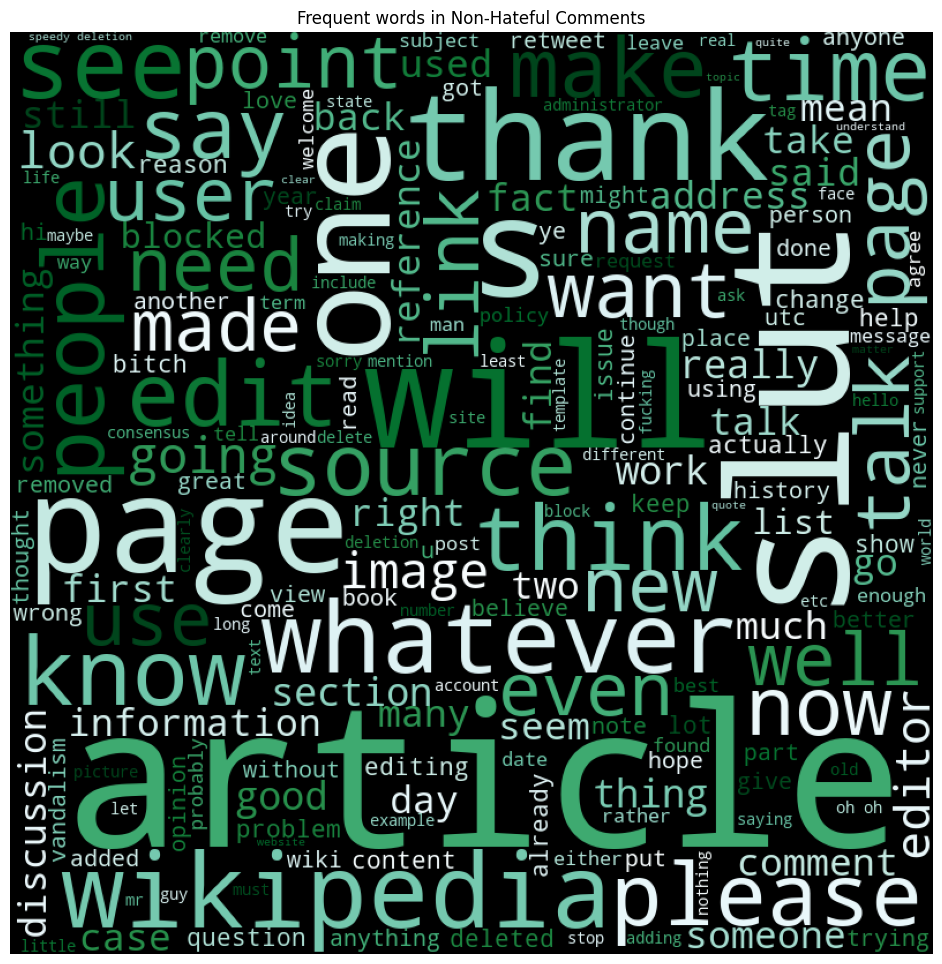

In [6]:
combined_title = ' '.join(df1['Content'])

wordcloud_img = WordCloud(width = 800, height = 800,
                            background_color ='Black', colormap = 'BuGn',
                            min_font_size = 10).generate(combined_title)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud_img)
plt.axis('off')
plt.title('Frequent words in Non-Hateful Comments')
plt.tight_layout(pad=2)
plt.show()

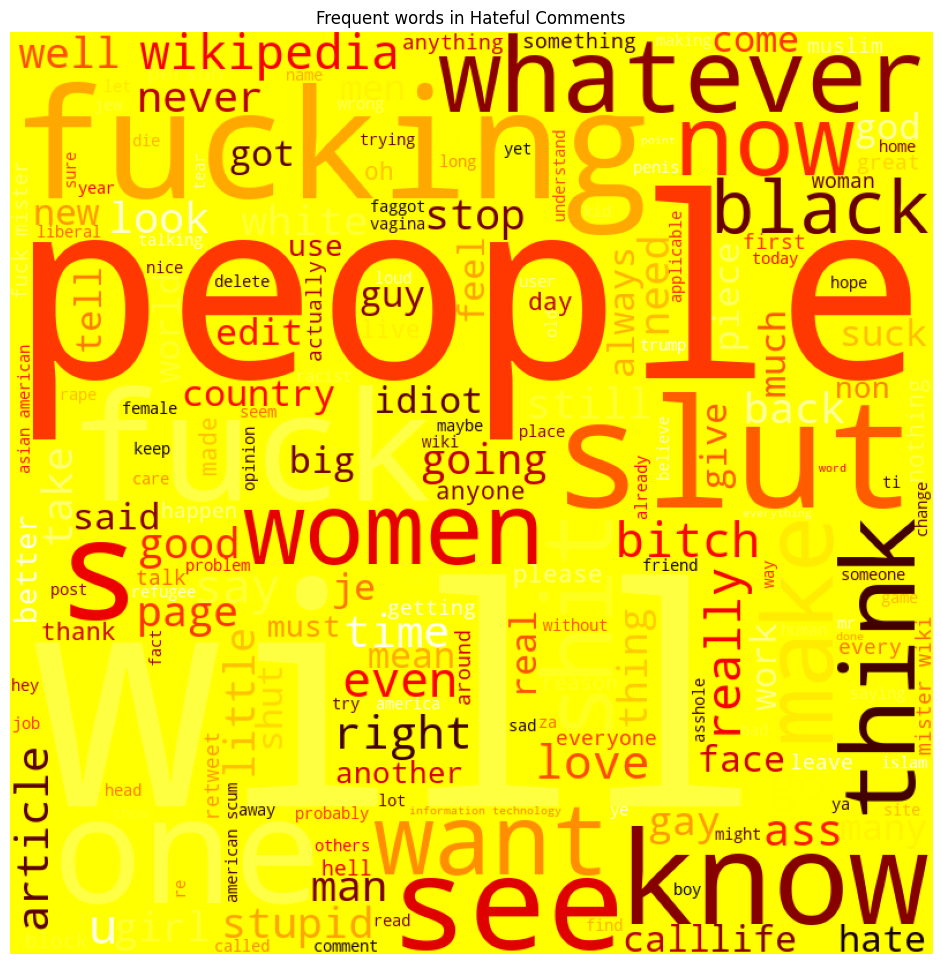

In [7]:
combined_title = ' '.join(df2['Content'])

wordcloud_img = WordCloud(width = 800, height = 800,
                            background_color ='Yellow', colormap = 'hot_r',
                            min_font_size = 10).generate(combined_title)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud_img)
plt.axis('off')
plt.title('Frequent words in Hateful Comments')
plt.tight_layout(pad=2)
plt.show()

In [8]:
data_tfidf = data.copy()

In [9]:
stopwords_l = stopwords.words('english')

punctuation = re.compile("[" + re.escape(string.punctuation) + "]")

lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('english') #Snowball stemmer initialised

def text_cleaning(text, mode="stemming"):
    res = []
    text_clean = re.sub(punctuation,'',text)
    tokens = word_tokenize(text_clean)
    
    for token in tokens:
        if token.lower() not in stopwords_l:
            if mode == "stemming":
                prepared_word = stemmer.stem(token)
            else:
                prepared_word = lemmatizer.lemmatize(token)            
            res.append(prepared_word)
    return ' '.join(res)

In [10]:
data_tfidf['cleaned_text'] = data_tfidf['Content'].apply(text_cleaning)

In [11]:
train, test = train_test_split(data_tfidf, test_size=0.3, stratify=data['Label'], random_state=42)

X_train = train['cleaned_text']
y_train = train['Label']

X_test = test['cleaned_text']
y_test = test['Label']

In [12]:
# TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_vect = tfidf_vectorizer.fit_transform(X_train)

X_test_vect = tfidf_vectorizer.transform(X_test)

In [13]:
linear_clf = LogisticRegression()

# train the model with training data processed using TF-IDF
linear_clf.fit(X_train_vect, y_train)

LogisticRegression()

In [14]:
y_pred_tf_idf = linear_clf.predict(X_test_vect)


report = classification_report(y_test, y_pred_tf_idf)
print(report)

display(pd.DataFrame({"Predicted: Unhateful": confusion_matrix(y_test, y_pred_tf_idf)[:, 0], 
              "Predicted: Hateful": confusion_matrix(y_test, y_pred_tf_idf)[:, 1]},
             index=['Actual: Unhateful', 'Actual: Hateful']))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1200
           1       0.76      0.79      0.78      1200

    accuracy                           0.77      2400
   macro avg       0.77      0.77      0.77      2400
weighted avg       0.77      0.77      0.77      2400



,Predicted: Unhateful,Predicted: Hateful
Actual: Unhateful,908,292
Actual: Hateful,253,947


In [15]:
train, validation = train_test_split(data, test_size=0.3, stratify=data['Label'], random_state=42)

In [16]:
# Define Dataset 
class HateSpeechDataset(Dataset):
    
    def __init__(self, data):
        
        # Initialize BERT tokenizer
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')        
        self.data = data
       
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        example = self.data.iloc[idx]

        text = example["Content"]
        label = example["Label"]

        # Tokenize the text
        encoding = self.tokenizer.encode_plus(text, padding='max_length', truncation=True, max_length=64, return_tensors='pt')
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"], ##.unsqueeze(0).int(),
            "label": label,
        }

train, validation = train_test_split(data, test_size=0.3, stratify=data['Label'], random_state=42)

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [21]:
# Define Dataset 
class HateSpeechDataset(Dataset):
    
    def __init__(self, data):
        
        # Initialize BERT tokenizer
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')        
        self.data = data
       
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        example = self.data.iloc[idx]

        text = example["Content"]
        label = example["Label"]

        # Tokenize the text
        encoding = self.tokenizer.encode_plus(text, padding='max_length', truncation=True, max_length=64, return_tensors='pt')
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"], ##.unsqueeze(0).int(),
            "label": label,
        }

In [23]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [25]:
dataset_train = HateSpeechDataset(train)
dataset_val = HateSpeechDataset(validation)

#data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Create DataLoader
batch_size = 128
dataloader_train = DataLoader(
    dataset_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    collate_fn=lambda x: {
        "input_ids": torch.stack([item["input_ids"] for item in x]),
        "attention_mask": torch.stack([item["attention_mask"] for item in x]),
        "labels": torch.tensor([item["label"] for item in x])
    },
    #collate_fn=data_collator,
    pin_memory=True,
)

dataloader_val = DataLoader(
    dataset_val,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    collate_fn=lambda x: {
        "input_ids": torch.stack([item["input_ids"] for item in x]),
        "attention_mask": torch.stack([item["attention_mask"] for item in x]),
        "labels": torch.tensor([item["label"] for item in x])
    },
    #collate_fn=data_collator,
    pin_memory=True,
)

In [26]:
# Define BERT classifier
class BERTClassifier(nn.Module):
    
    def __init__(self):
        
        # Specify network layers
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        
        self.linear = nn.Linear(self.bert.config.hidden_size, 1)
        
        # Define dropout
        self.dropout = nn.Dropout(0.1)
        
        # Freeze BERT layers
        for n, p in self.bert.named_parameters():
            p.requires_grad = False
            
    def forward(self, text, masks):
        #output_bert = self.bert(text, attention_mask=masks).last_hidden_state.mean(axis=1)
        #print(output_bert.last_hidden_state)
        #print(self.bert.config.hidden_size)
        
        output_bert = self.bert(text, attention_mask=masks).last_hidden_state
        output_bert = self.avg_pool(output_bert.transpose(1, 2)).squeeze(-1)
        
        return self.linear(self.dropout(output_bert))

In [27]:
model = BERTClassifier()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [28]:
# Define optimiser, objective function and epochs
optimizer = optim.Adam(model.parameters(), lr=0.001) #optim.AdamW(model.parameters(), lr=5e-5) #
criterion = nn.BCEWithLogitsLoss()
epochs = 5

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
model.to(device)

val_losses = []
train_losses = []

# Train model
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================

    model.train()
    print(f"Start training epoch {epoch_i}...")
    total_train_loss = 0
    for i, batch in enumerate(tqdm(dataloader_train)):
    
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        masks = batch['attention_mask'].to(device)
        label = batch['labels'].to(device) 

        output = model(input_ids, masks)
        loss = criterion(output.squeeze(), label.float())

        loss.backward()
        
        # Clip the norm of the gradients to 1.0 to prevent the "exploding gradients".
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_train_loss += loss.item()
        
    avg_train_loss = total_train_loss / len(dataloader_train)
    train_losses.append(avg_train_loss)
    # ========================================
    #               Validation
    # ========================================
    
    model.eval()
    print("Start validation...")
    y_true_bert = list()
    y_pred_bert = list()
    
    total_eval_loss = 0.0
    with torch.no_grad():
        for batch in dataloader_val:
            input_ids = batch['input_ids'].to(device)
            masks = batch['attention_mask'].to(device)
            label = batch['labels'].to(device)
            
            output = model(input_ids, masks)
            max_output = (torch.sigmoid(output).cpu().numpy().reshape(-1)>= 0.5).astype(int)
            y_true_bert.extend(label.tolist())
            y_pred_bert.extend(max_output.tolist())
            
            loss_v = criterion(output.squeeze(), label.float())
            total_eval_loss += loss.item()
    avg_val_loss = total_eval_loss / len(dataloader_val)
    val_losses.append(avg_val_loss)
    
    print(f"Metrics after Epoch {epoch_i}")     
    print(f"Accuracy : {accuracy_score(y_true_bert, y_pred_bert)}")
    print(f"Presision: {np.round(precision_score(y_true_bert, y_pred_bert),3)}")
    print(f"Recall: {np.round(recall_score(y_true_bert, y_pred_bert),3)}") 
    print(f"F1: {np.round(f1_score(y_true_bert, y_pred_bert),3)}")
    print("   ") 

Start training epoch 0...


  0%|          | 0/44 [00:00<?, ?it/s]

In [ ]:
print('Test accuracy: {:.2f}'.format(accuracy_score(y_true_bert, y_pred_bert)))
print('\nClassification report: \n', classification_report(y_true_bert, y_pred_bert))
print('\nConfusion matrix: \n')
display(pd.DataFrame({"Predicted: Unhateful": confusion_matrix(y_true_bert, y_pred_bert)[:, 0], 
              "Predicted: Hateful": confusion_matrix(y_true_bert, y_pred_bert)[:, 1]},
             index=['Actual: Unhateful', 'Actual: Hateful']))

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
training_args = TrainingArguments(output_dir="test_trainer", report_to="none")

In [ ]:
metric_acc = evaluate.load("accuracy")
metric_prec = evaluate.load("precision")
metric_recall = evaluate.load("recall")

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = metric_acc.compute(predictions=predictions, references=labels)["accuracy"]
    prec = metric_prec.compute(predictions=predictions, references=labels)["precision"]
    rec = metric_recall.compute(predictions=predictions, references=labels)["recall"]
    
    return {"accuracy": acc,"precision": prec, "recall": rec}

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')    
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
    compute_metrics=compute_metrics,
    data_collator = data_collator
    
)

In [ ]:
trainer.train()

In [ ]:
model.eval()
print("Start validation...")
y_true_auto_bert  = list()
y_pred_auto_bert = list()

total_eval_loss = 0.0
with torch.no_grad():
    for batch in dataloader_val:
        input_ids = batch['input_ids'].to(device)
        masks = batch['attention_mask'].to(device)
        label = batch['labels'].to(device)

        output = model(input_ids, masks)
        max_output = np.argmax(output.logits.cpu().numpy(), axis=-1)
        y_true_auto_bert.extend(label.tolist())
        y_pred_auto_bert.extend(max_output.tolist())


print(f"Accuracy : {accuracy_score(y_true_auto_bert, y_pred_auto_bert)}")
print(f"Presision: {np.round(precision_score(y_true_auto_bert, y_pred_auto_bert),3)}")
print(f"Recall: {np.round(recall_score(y_true_auto_bert, y_pred_auto_bert),3)}") 
print(f"F1: {np.round(f1_score(y_true_auto_bert, y_pred_auto_bert),3)}")
print("   ")  


print('Test accuracy: {:.2f}'.format(accuracy_score(y_true_auto_bert, y_pred_auto_bert)))
print('\nClassification report: \n', classification_report(y_true_auto_bert, y_pred_auto_bert))
print('\nConfusion matrix: \n')
display(pd.DataFrame({"Predicted: Unhateful": confusion_matrix(y_true_auto_bert, y_pred_auto_bert)[:, 0], 
              "Predicted: Hateful": confusion_matrix(y_true_auto_bert, y_pred_auto_bert)[:, 1]},
             index=['Actual: Unhateful', 'Actual: Hateful']))